In this first notebook we're going to proceed with a preliminary data exploration.
In particular, the main task will be to compare sensors' samples in different activities and to discover some differences in the same activity, but done by different subjects.

In [19]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
sys.path.append("creation_functions")

In [20]:
from creation_functions.visualization import have_a_look_at
from creation_functions.utilities import get_some_filter

In [21]:
ACTIVITY_CODES = ["dws", "jog", "sit", "std", "ups", "wlk"]

TRIAL_CODES = {
    ACTIVITY_CODES[0]:[1,2,11],
    ACTIVITY_CODES[1]:[9,16],
    ACTIVITY_CODES[2]:[5,13],
    ACTIVITY_CODES[3]:[6,14],
    ACTIVITY_CODES[4]:[3,4,12],
    ACTIVITY_CODES[5]:[7,8,15]
}

ACTORS = np.linspace(1, 24, 24).astype(int)

### Which Dataset we are looking at?
We load _raw_dataset.csv_ and we take a first look at samples. This .csv has been created through the function **create_time_series(mode="raw")** in the file _utilities.py_. In particualar:
- We recursively select all files in the _MotionSenseDataset_, and from each filename we can associate a signal to a particular subject and to a specific trial of the original experiment. We use fixed dictionaries declared above to associate each trial to the correspondant activity.
- We selected in the function only a subset of the sensors used in the original experiment; in particular, we dropped the "attitude" sensor (along all axes) because we have too much different sensors in our phone. So, thinking about comparing the entire work with some personal experiments, we decided to leave it out.

In [22]:
raw_dataset = pd.read_csv("processed_dataset/raw_dataset.csv")

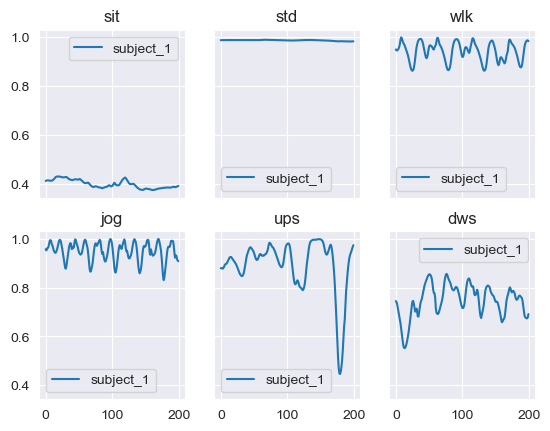

In [23]:
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)
have_a_look_at(raw_dataset, ["sit"], ["gravity.y"], ax[0][0], actors=[1])
have_a_look_at(raw_dataset, ["std"], ["gravity.y"], ax[0][1], actors=[1])
have_a_look_at(raw_dataset, ["wlk"], ["gravity.y"], ax[0][2], actors=[1])
have_a_look_at(raw_dataset, ["jog"], ["gravity.y"], ax[1][0], actors=[1])
have_a_look_at(raw_dataset, ["ups"], ["gravity.y"], ax[1][1], actors=[1])
have_a_look_at(raw_dataset, ["dws"], ["gravity.y"], ax[1][2], actors=[1])

Signals seems to have different shape, and that's a good thing. To better analyse signal shapes among different actors, we implemented two function (you can find it implemented in _visualization.py_ and in _utilities.py_:
- **have_a_look_at(dataset, activity, signal, ax, actor)** plots a window of the input signal and activity of a specific user-specified actor.
- **get_some_filter(dataset, actors, activities)** filters the dataset and returns only input-actors performing only input-activities

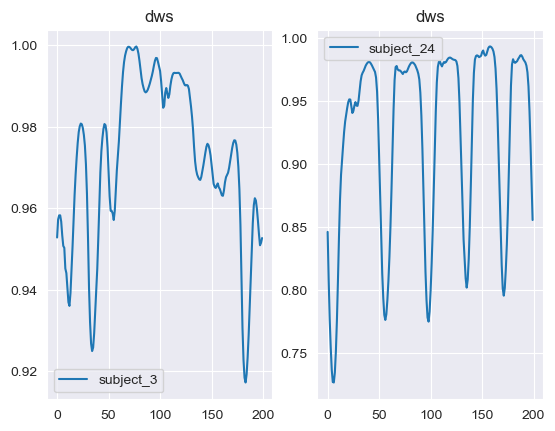

In [24]:
fig, ax = plt.subplots(1, 2)
have_a_look_at(raw_dataset, ["dws"], ["gravity.y"], ax[0], actors=[3])
have_a_look_at(raw_dataset, ["dws"], ["gravity.y"], ax[1], actors=[24])

In [25]:
raw_dataset.isna().sum()

Unnamed: 0            0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
class                 0
subject               0
trial                 0
dtype: int64

As we can see we don't have null values in the dataset.

[Text(0.5, 1.0, 'Class Distribution (Raw Data)')]

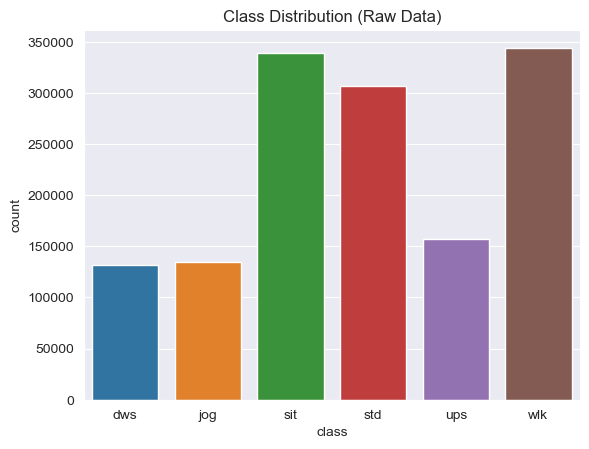

In [26]:
sns.countplot(x="class",data=raw_dataset).set(title="Class Distribution (Raw Data)")

The classes distribution is not so equal. In the next phases we'll have to deal with rebalancing these numbers.

In [27]:
# Have a look a some signals for sitting
ACTIVITY_CODES_s = ["sit"]
TRIAL_CODES_s = { ACTIVITY_CODES_s[0]:[13]}
sitting_subjects = get_some_filter(raw_dataset,[5, 6, 7, 8, 9, 10], ["sit"])
sitting_subjects = sitting_subjects.loc[sitting_subjects["trial"] == 13]

Text(0.5, 1.0, 'Different lenght of Trial 13 (Sitting) for some subjects')

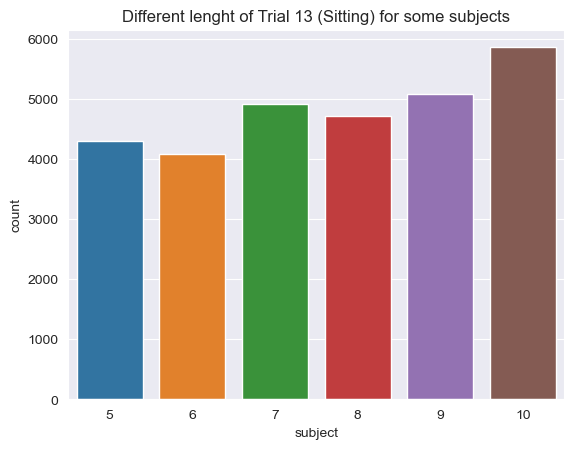

In [28]:
# Trials seem to have different duration
sns.countplot(x="subject", data=sitting_subjects)
plt.title("Different lenght of Trial 13 (Sitting) for some subjects")

The length of trials seems to be quite similar between different subjects.

Text(0.5, 0.98, 'Comparison sitting activity between different subjects, userAcceleration.x')

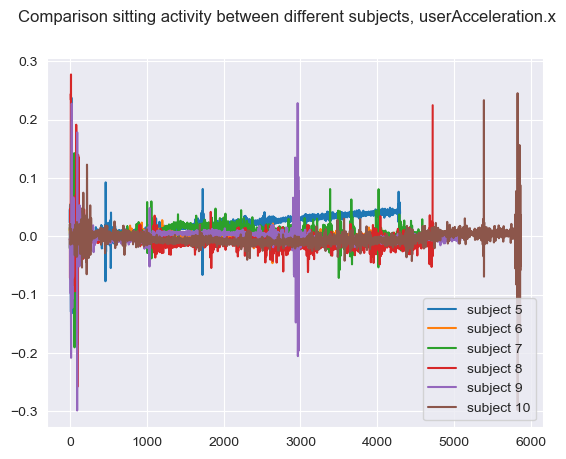

In [29]:
labels = ["subject 5", "subject 6", "subject 7", "subject 8", "subject 9", "subject 10"]
for i in [5, 6, 7, 8, 9, 10]:
    plt.plot(sitting_subjects.loc[sitting_subjects["subject"] == i]["userAcceleration.x"].reset_index()["userAcceleration.x"])
plt.legend(labels)
plt.suptitle("Comparison sitting activity between different subjects, userAcceleration.x")

Text(0.5, 0.98, 'Comparison sitting activity between different subjects, userAcceleration.y')

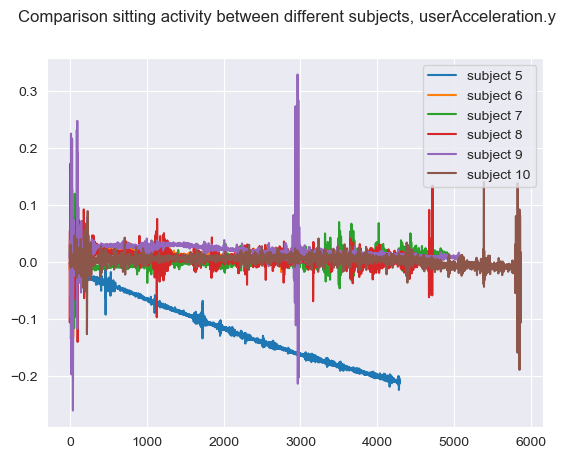

In [30]:
labels = ["subject 5", "subject 6", "subject 7", "subject 8", "subject 9", "subject 10"]
for i in [5, 6, 7, 8, 9, 10]:
    plt.plot(sitting_subjects.loc[sitting_subjects["subject"] == i]["userAcceleration.y"].reset_index()["userAcceleration.y"])
plt.legend(labels)
plt.suptitle("Comparison sitting activity between different subjects, userAcceleration.y")

We can notice that subject 5 has a strange behaviour: the accelerometer measuring the user acceleration over y is giving this descending trend, which is somehow unnatural.

Text(0.5, 0.98, 'Comparison sitting activity between different subjects, userAcceleration.z')

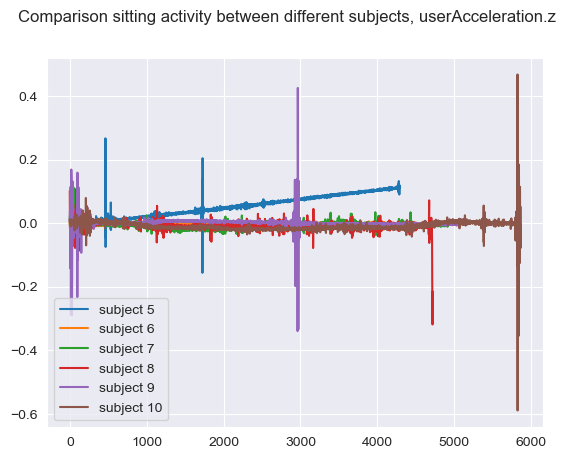

In [31]:
labels = ["subject 5", "subject 6", "subject 7", "subject 8", "subject 9", "subject 10"]
for i in [5, 6, 7, 8, 9, 10]:
    plt.plot(sitting_subjects.loc[sitting_subjects["subject"] == i]["userAcceleration.z"].reset_index()["userAcceleration.z"])
plt.legend(labels)
plt.suptitle("Comparison sitting activity between different subjects, userAcceleration.z")

### What did we discover?
- Raw dataset is not affected by NaN values. Even if this seems a good point, we will discover later that some null values can appear during feature_extraction phase, due to fourier transform (see next notebook for more information)
- Dataset seems unbalanced. Even if actors gives us approx. the same fraction of the total samples of a fixed activity, in the end we have some activities, like _downstairs_ and _jogging_ which appears really less frequent than the others. We will deal with this problem, that is derived by the lengths of the correspondant trials, that last less time than the others.
- Subject 5 had a really strange behave during a sitting trial. We performed a lot of checks, and we find out that he is the only one having this type of behave. Maybe for a bad sensor work, or maybe because he didn't follow experiment instructions. We decided to just leave out his samples for that trial.
